# 🔥포스🔥

### 위 게시글을 시리즈물📖입니다.  
**[1편. OpenCV의 기초, Numpy와 Matplotlib](https://dacon.io/codeshare/4768?page=1&dtype=recent)**<br>
**[2편. OpenCV 기초(이미지 입출력, 그리기, 창 관리, 이벤트 처리 등)](https://dacon.io/codeshare/4837?page=1&dtype=recent)**<br>
**[3편. 이미지 프로세싱(컬러 스페이스, 스레시홀딩, 이미지 연산, 히스토그램)](https://dacon.io/codeshare/4858?page=1&dtype=recent)**<br>
**[4편. OpenCV 기하학적 변환](https://dacon.io/codeshare/4875?page=1&dtype=recent)**<br>
**[5편. OpenCV 영상필터](https://dacon.io/codeshare/4898?page=1&dtype=recent)**<br>
**[프로젝트1편. Multi-Hand Gesture Recognition(1)](https://dacon.io/codeshare/4956?page=1&dtype=recent)**<br>
**[프로젝트2편. Multi-Hand Gesture Recognition(2)](https://dacon.io/codeshare/5006?page=1&dtype=recent)**<br>
**[6편. OpenCV 영상분할](https://dacon.io/codeshare/5072?page=1&dtype=recent&fType=)**<br>
**[7편. OpenCV 영상매칭과 추척](https://dacon.io/codeshare/5106)**<br>
**[8편. OpenCV과 머신러닝편(1)(K-means, K-NN, SVM)](https://dacon.io/codeshare/5146?page=1&dtype=recent&fType=)**    
**[8편.OpenCV과 머신러닝편(2)(HOG, BOW, 케스케이드 분류기)](https://dacon.io/codeshare/5179)**



<br>
<br>

**프로젝트 게시글**<br>
**[프로젝트 1편. Segmentation Modeling(1) (U-Net, OpenCV 적용)](https://dacon.io/codeshare/5185)**<br>
**[프로젝트 2편. Segmentation Modeling(1) (ResU-Net, OpenCV 적용)](https://dacon.io/codeshare/5186?page=1&dtype=recent&fType=)**

* 안녕하세요 :) 데이크루 2기 *포스팀*입니다!
* 저희 마지막 프로젝트 게시글에 들어와주셔서 감사합니다!
* 이제 정말 마지막 게시글이네요! 마지막까지 많은 관심 부탁드려용 ~

주제는!!! 동일하게,

✨
## **Segmentation Modeling(분할 모델링)**
✨


가장 어려운 모형에 대하여 공부해보겠습니다! 얘는 인터넷에 설명도 잘 안 나와있어요..!

## 목차

### 1) RPA_ResU-NET 이란?
### 2) 데이터 설명
### 3) Code
#### 3-1) Data Augmentation 적용 x
#### 3-2) 논문 Data Augmentation 적용 o
#### 3-3) OpenCV 적용
### 4) 결론

# 그럼 시작합니다 ~:)


### 1) RPA_ResU-Net : Refined Position of Attention network for ResUNet

#### 1-1) ASPP
- ResU-Net과 마찬가지로 deep convolution network는 layer를 쌓아감에 있어서,layer가 깊어질수록 feature map의 size가 줄어들고 detail한 feature를 추출하기 어려워집니다.

- 기존의 **spatial pyramid pooling network**에서 각 convolution을 atrous convolution으로 변환하여 여러개의 확대된 receptive field를 가진 filter를 합쳐 feature를 추출하기위한 범위를 넓혀주었습니다.

In [ ]:
import torch
import torch.nn as nn

class ASPP(nn.Module):
    def __init__(self, in_dims, out_dims, rate=[6, 12, 18]):
        super(ASPP, self).__init__()
        
        self.aspp_block1 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[0], dilation=rate[0]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block2 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[1], dilation=rate[1]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block3 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[2], dilation=rate[2]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )

        self.output = nn.Conv2d(len(rate) * out_dims, out_dims, 1)
        self._init_weights()

    def forward(self, x):
        x1 = self.aspp_block1(x)
        x2 = self.aspp_block2(x)
        x3 = self.aspp_block3(x)
        out = torch.cat([x1, x2, x3], dim=1)
        return self.output(out)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

#### 1-2) Attention network

- Attention은 특정 model이 집중해야할 부분에 더 중요도를 두고 학습을하도록 도와주는 module입니다. convolution operation은 channel, spatial information으로 feature를 추출합니다. 
- 기존의 attention은 "where", 즉 어디에 집중해야하는지에 초점을 맞추었다면, 이번에 적용할 CBAM에서 사용된 spatial attention과 channel attention은 각각 **"where"(어디에 집중)**과 **"what"(무엇에 집중)**에 대해 집중하며 서로 보완적이고, 이들은 서로 학습을 돕습니다.

- 이 중에서도 **Spatial Attention**은 average pooling과 max pooling을 channel axis로 수행. (1xHxW) 합니다. channel axis로 수행한 pooling -> spatial information을 강조합니다.

- **Channel Attention**은 Channel에 대한 집중을 돕기위해 max pooling을 동시에 사용하여 병렬로 연결합니다.

In [1]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
                
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

#### 1-3) RPA_ResU-Net
- spatial attention을 encoder의 input block, channel attention을 encoder의 final block에 위치시킵니다. ASPP는 UNet++ 및 double UNet에서 encoder-decoder structure의
bridge에 사용하여 그대로 차용합니다.
- 이때, 해당 class에 없는 코드는 ResU-Net과 동일합니다.


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, padding):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1),
        ) 
    
    def forward(self, inputs):
        r = self.conv_block(inputs)
        s = self.shortcut(inputs)
        
        skip = r + s
        return skip
    
class RPAResUNet(nn.Module):
    def __init__(self, num_classes):
        super(RPAResUNet, self).__init__()
        self.num_classes = num_classes
        
        """ Input block -> residual layer """
        self.residual_1_a = self.input_block(in_channels=3, out_channels=32)
        self.residual_1_b = self.input_skip(in_channels=3, out_channels=32)
        # input block -> spatial attention
        self.spatial_attention = SpatialAttention()
        
        """ Residual block x 3, Encoding """
        self.residual_2 = ResidualBlock(32, 64, 2, 1)
        self.residual_3 = ResidualBlock(64, 128, 2, 1)
        self.residual_4 = ResidualBlock(128, 256, 2, 1)
        
        """ Bridge block, ASPP """
        # 3 -> 32, 1024 -> 512, computation cost
        self.bridge_aspp = ASPP(256, 512)
        
        """ Last Encoder layer <- channel attention """
        self.channel_attention = ChannelAttention(512)
        
        """ Residual block x3, Decoding 1st block """
        # upsample out_feature 512 -> 256 ?
        self.upsample_block_1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, 
                                          kernel_size=2, stride=2, padding=0)
        self.residual_5 = ResidualBlock(512+128, 256, 1, 1) # upsampling + residual_3
        
        """ 2nd Residual block, Decoder """
        self.upsample_block_2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, 
                                          kernel_size=2, stride=2, padding=0)
        self.residual_6 = ResidualBlock(256+64, 128, 1, 1)
        
        """ 3rd Residual block, Decoder """
        self.upsample_block_3 = nn.ConvTranspose2d(in_channels=128, out_channels=128, 
                                          kernel_size=2, stride=2, padding=0)
        self.residual_7 = ResidualBlock(128+32, 64, 1, 1)
        
        """ output block """
        self.output_aspp = ASPP(64, 32)
        self.output = nn.Sequential(
          nn.Conv2d(in_channels=32, out_channels=num_classes, kernel_size=1),
          nn.Sigmoid(),
        )
        
    def input_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    )
        return block
    
    def input_skip(self, in_channels, out_channels):
        skip = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        return skip 

    def forward(self, X):
        residual_1_a_out = self.residual_1_a(X)
        residual_1_b_out = self.residual_1_b(X)
        residual_1_out = residual_1_a_out + residual_1_b_out
        spatial_attention_out = self.spatial_attention(residual_1_out) * residual_1_out
        
        residual_2_out = self.residual_2(spatial_attention_out)
        residual_3_out = self.residual_3(residual_2_out)
        residual_4_out = self.residual_4(residual_3_out)
        
        bridge_aspp_a = self.bridge_aspp(residual_4_out)
        channel_attention_out = self.channel_attention(bridge_aspp_a) * bridge_aspp_a
        
        """ decoder block without attention modules """
        
        upsample_1_out = self.upsample_block_1(channel_attention_out)
        residual_5_out = self.residual_5(torch.cat((upsample_1_out, residual_3_out), dim=1))
        
        upsample_2_out = self.upsample_block_2(residual_5_out)
        residual_6_out = self.residual_6(torch.cat((upsample_2_out, residual_2_out), dim=1))
        
        upsample_3_out = self.upsample_block_3(residual_6_out)
        residual_7_out = self.residual_7(torch.cat((upsample_3_out, residual_1_out), dim=1))
        
        output_aspp_b = self.output_aspp(residual_7_out)
        out = self.output(output_aspp_b)
        return out
        
model = RPAResUNet(num_classes=1)
#print(model)

### 사용한 판단 척도

위 게시글에서 판단 척도로는 loss값과 IoU값이 있습니다. IoU값의 식은 **(두 이미지의 교집합)/(두 이미지의 합집합)** 으로 나타낼 수 있습니다.

아래는 구현한 식 입니다.

In [2]:
def iou(pred, target, n_classes = 2):
    
    iou = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()
        union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection

        if union == 0:
            iou.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            iou.append(float(intersection) / float(max(union, 1)))

    return sum(iou)

In [3]:
def iou_metric(y_pred, y_true, n_classes = 2):
    miou = []
    for i in np.arange(0.5, 1.0, 0.05):
        y_pred_ = (y_pred > i)
        iou_init = iou(y_pred_, y_true, n_classes = n_classes)
        miou.append(iou_init)
    
    return sum(miou)/len(miou)

### 2) 데이터 설명

이전 게시글에서 했던 데이터와 동일한 데이터를 사용하였습니다. 데이터 출처는 https://www.kaggle.com/competitions/data-science-bowl-2018 입니다.

- /stage1_train/* : train 세트 이미지 (images and annotated masks)  
- /stage1_test/* : test 이미지 (images only, you are predicting the masks)

### 3) Code

구글 드라이브 연동

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


패키지 불러오기

In [5]:
from grpc import Channel

import os
import random
from pickletools import optimize
from cv2 import transform
from matplotlib.pyplot import axis
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
from skimage import io, transform
from skimage.io import imread
import shutil

import numpy as np
import matplotlib.pyplot as plt

시드 고정

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

GPU 설정

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

필요한 파라미터 설정

In [8]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
width_out = 128
height_out = 128

In [1]:
# %cd (자신의 경로)

데이터 ZIP 파일 풀어주기

In [ ]:
#!unzip dataset.zip

In [10]:
!ls

 dataset       ResU_Net_transformation_O.ipynb	 unet-iou-cvc.pt   x_train.npy
 dataset.zip   RPAResU_Net.ipynb		 U_net.ipynb	   y_train.npy
 __MACOSX     'Unet (1).ipynb'			 Unet.ipynb


데이터 불러오기

- 이전 게시글에서 만들었던 numpy array를 이용해서 바로 진행하겠습니다! 따라서 저번에 만들었던 npy파일을 불러옵니다.

In [23]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

In [ ]:
for i, id_ in enumerate(train_ids):
    path = TRAIN_PATH + id_
    img = cv2.imread(path+'/images/'+id_+'.png')
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    x_train[i] = img

    mask = np.zeros((height_out, width_out, 1), dtype=bool)
    mask_path = path+'/masks/'
    for id_ in os.listdir(mask_path):
        mask_ = cv2.imread(mask_path+id_, 0)
        mask_ = cv2.resize(mask_, (height_out, width_out))
        mask_ = np.expand_dims(mask_, axis=-1)
        mask = np.maximum(mask, mask_)
    y_train[i] = mask

### 1) **Data Augmentation 없이 학습**

- 첫번째로 별도의 과정 없이 기본 이미지만을 가지고 학습을 시키고 결론을 내어보겠습니다! 

custom dataset인 ResUNETDataset class 정의

In [24]:
class ResUNetDataset(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
        
    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return image, mask

tensor로 변환된 데이터를 이용한 DataLoader 생성

In [28]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)
train_dataset = ResUNetDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataset = ResUNetDataset(x_val, y_val)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

앞서 봤던 RPA-ResU-NET 정의

In [29]:
model = RPAResUNet(num_classes=1).to(device)

parameter 정의
- RPAResUNet 경우 epoch=25로 Train 했을 시 상당한 시간이 소모되어 편의상 **epoch=5**로 실험하였습니다.

In [30]:
epochs=5
alpha=5
batch_size = 16
criterion=nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Train

In [31]:
train_loss_list = []
val_loss_list = []
train_iou_list = []
val_iou_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_iou = 0
    train_sum_iou = 0

    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model(image.float())
        # outputs = outputs.permute(0, 2, 3, 1)
        # outputs = outputs.reshape(batch_size*IMG_HEIGHT*IMG_WIDTH, 2)
        # mask = mask.reshape(batch_size*height_out*width_out)

        loss = criterion(outputs.float(), mask.float())
        train_loss += loss

        train_iou += iou_metric(outputs, mask)
        train_sum_iou += train_iou
        rev_iou = 16 - iou_metric(outputs, mask)
        loss += alpha * rev_iou

        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_iou = 0

        for image_val, mask_val in valid_loader: 
            image_val = image_val.to(device)
            mask_val = mask_val.to(device)
            output_val = model(image_val.float())
            valid_loss += criterion(output_val.float(), mask_val.float())
            valid_iou += iou_metric(output_val, mask_val)

    print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "Validation Loss: ", valid_loss/len(valid_loader))
    print("Training IoU: ", train_iou/len(train_loader), "Validation IoU: ", valid_iou/len(valid_loader))

    # visualization
    train_loss_list.append(train_loss/len(train_loader))
    val_loss_list.append(valid_loss/len(valid_loader))
    train_iou_list.append(train_iou/len(train_loader))
    val_iou_list.append(valid_iou/len(valid_loader))
    
print("Mean IoU: ", train_sum_iou/epochs)

Epoch  1  Training Loss:  tensor(0.7907, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.7399)
Training IoU:  0.16289421777380284 Validation IoU:  0.011174224428376773
Epoch  2  Training Loss:  tensor(0.7364, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.7836)
Training IoU:  0.23649703380224893 Validation IoU:  0.23544798637459152
Epoch  3  Training Loss:  tensor(0.7083, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.6931)
Training IoU:  0.42935843990939304 Validation IoU:  0.2997049804886628
Epoch  4  Training Loss:  tensor(0.6749, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.6755)
Training IoU:  0.5931483202009239 Validation IoU:  0.3470908325702785
Epoch  5  Training Loss:  tensor(0.6715, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.7104)
Training IoU:  0.5718807010530412 Validation IoU:  0.4518637712180266
Mean IoU:  31.435191204977116


Loss, IoU 값 시각화

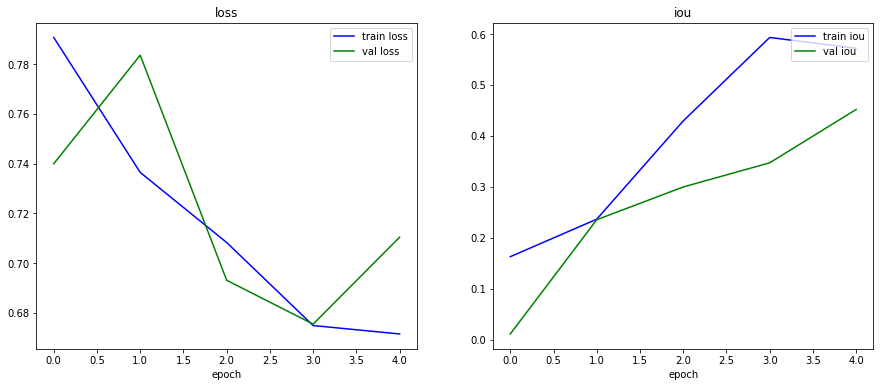

In [32]:
train_loss_data = [i.detach().cpu().numpy() for i in train_loss_list]
val_loss_data = [i.detach().cpu().numpy() for i in val_loss_list]
# train_iou_data = [i.detach().cpu().numpy() for i in train_iou_list]
# val_iou_data = [i.detach().cpu().numpy() for i in val_iou_list]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.plot(train_loss_data, 'b', label='train loss')
plt.plot(val_loss_data, 'g', label='val loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('iou')
plt.xlabel('epoch')
plt.plot(train_iou_list, 'b', label='train iou')
plt.plot(val_iou_list, 'g', label='val iou')
plt.legend(loc='upper right')

plt.show()

TEST 실제값, 예측값 시각화

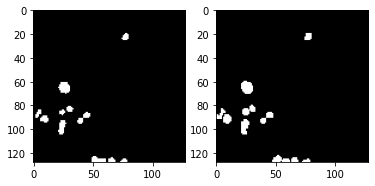

In [33]:
""" prediction / ground truth visualization """
for img_, mask_ in valid_loader:
    img = img_[1].to(device)
    img.unsqueeze_(0)
    mask_pred = model(img.float())
    mask_pred = mask_pred.cpu()
    mask_pred = (mask_pred > 0.75)
    mask_true = mask_[1]

    img = TF.to_pil_image(mask_pred.float().squeeze(0))
    mask = TF.to_pil_image(mask_true)

    img = np.array(img)
    mask = np.array(mask)

    fig, (axis_1, axis_2) = plt.subplots(1, 2)
    axis_1.imshow(img.astype(np.uint8), cmap='gray')
    axis_2.imshow(mask.astype(np.uint8), cmap='gray')
    plt.show()

    break

# PATH = 'unet-iou-cvc.pt'
# torch.save(model.state_dict(), PATH)

- - 아무런 Data Augmentation 기법 없이 진행되었을 때는 마지막 epoch에서 Train IoU가 0.57, Validation IoU가 0.45 정도입니다!
- 실제값과 예측값을 시각화 해보았을 때, 조금의 학습만으로도 비슷한 위치에 있는 것을 확인할 수 있습니다.
- 또한, 25 epoch까지 돌려보았을 때, 엄청 높은 IoU값을 가지고 있었습니다!

### **2) 논문 Data Augmentation 기법 적용 후 학습**

- 다음은 앞서 얘기한 논문에서의 전처리 방법을 적용하였습니다.
- Overlap-tile과 center_Crop 그리고 Elastic 변환 방법을 적용하였습니다.

custom dataset인 ResUNETDataset class 정의

In [34]:
class ResUNetDataset(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))
        
        image = TF.pad(image, padding = 20, padding_mode = 'reflect')
        mask = TF.pad(mask, padding = 20, padding_mode = 'reflect')
        
        angle = random.uniform(-10, 10)
        width, height = image.size
        max_dx = 0.1 * width
        max_dy = 0.1 * height
        translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
        scale = random.uniform(0.8, 1.2)
        shear = random.uniform(-0.5, 0.5)
        image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
        mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
        
        image = TF.center_crop(image, (128, 128))
        mask = TF.center_crop(mask, (128, 128))
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
        
    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return image, mask

tensor로 변환된 데이터를 이용한 DataLoader 생성

In [37]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

In [38]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

In [39]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)
train_dataset = ResUNetDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataset = ResUNetDataset(x_val, y_val)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

앞서 봤던 RPA-ResU-NET 정의

In [40]:
model2 = RPAResUNet(num_classes=1).to(device)

parameter 정의

In [41]:
epochs=5
alpha=5
batch_size = 16
criterion=nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-3)

Training

In [42]:
train_loss_list = []
val_loss_list = []
train_iou_list = []
val_iou_list = []

for epoch in range(epochs):
    model2.train()
    train_loss = 0
    train_iou = 0
    train_sum_iou = 0

    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model2(image.float())
        # outputs = outputs.permute(0, 2, 3, 1)
        # outputs = outputs.reshape(batch_size*IMG_HEIGHT*IMG_WIDTH, 2)
        # mask = mask.reshape(batch_size*height_out*width_out)

        loss = criterion(outputs.float(), mask.float())
        train_loss += loss

        train_iou += iou_metric(outputs, mask)
        train_sum_iou += train_iou
        rev_iou = 16 - iou_metric(outputs, mask)
        loss += alpha * rev_iou

        loss.backward()
        optimizer.step()

    model2.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_iou = 0

        for image_val, mask_val in valid_loader: 
            image_val = image_val.to(device)
            mask_val = mask_val.to(device)
            output_val = model2(image_val.float())
            valid_loss += criterion(output_val.float(), mask_val.float())
            valid_iou += iou_metric(output_val, mask_val)

    print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "Validation Loss: ", valid_loss/len(valid_loader))
    print("Training IoU: ", train_iou/len(train_loader), "Validation IoU: ", valid_iou/len(valid_loader))

    # visualization
    train_loss_list.append(train_loss/len(train_loader))
    val_loss_list.append(valid_loss/len(valid_loader))
    train_iou_list.append(train_iou/len(train_loader))
    val_iou_list.append(valid_iou/len(valid_loader))
    
print("Mean IoU: ", train_sum_iou/epochs)

Epoch  1  Training Loss:  tensor(0.7827, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.7091)
Training IoU:  0.23978430972173062 Validation IoU:  0.0074230353251716445
Epoch  2  Training Loss:  tensor(0.7048, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.7093)
Training IoU:  0.4802778345702498 Validation IoU:  0.48476384040528797
Epoch  3  Training Loss:  tensor(0.6759, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.6672)
Training IoU:  0.6216836370149273 Validation IoU:  0.44655095858695865
Epoch  4  Training Loss:  tensor(0.6570, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.6657)
Training IoU:  0.6950840405781658 Validation IoU:  0.6866548913183509
Epoch  5  Training Loss:  tensor(0.6572, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.6805)
Training IoU:  0.6813420615676375 Validation IoU:  0.6495490720934414
Mean IoU:  41.5705592099958


Loss, IoU 값 시각화

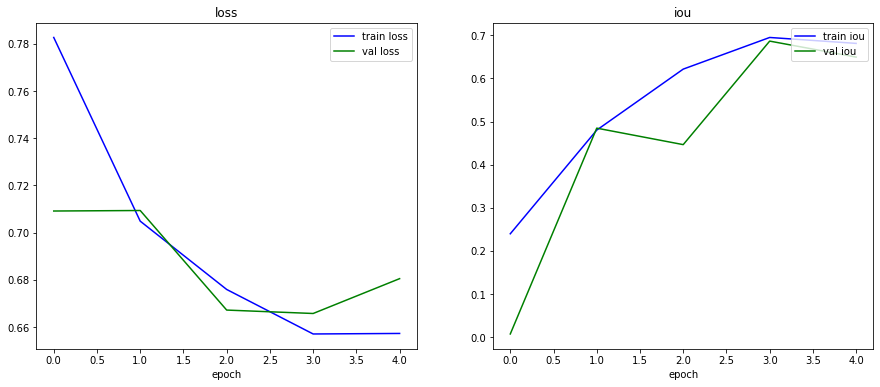

In [43]:
train_loss_data = [i.detach().cpu().numpy() for i in train_loss_list]
val_loss_data = [i.detach().cpu().numpy() for i in val_loss_list]
# train_iou_data = [i.detach().cpu().numpy() for i in train_iou_list]
# val_iou_data = [i.detach().cpu().numpy() for i in val_iou_list]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.plot(train_loss_data, 'b', label='train loss')
plt.plot(val_loss_data, 'g', label='val loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('iou')
plt.xlabel('epoch')
plt.plot(train_iou_list, 'b', label='train iou')
plt.plot(val_iou_list, 'g', label='val iou')
plt.legend(loc='upper right')

plt.show()

TEST 실제값, 예측값 시각화

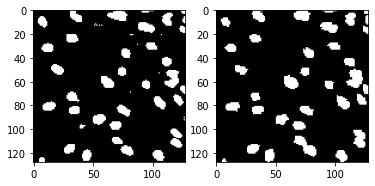

In [44]:
""" prediction / ground truth visualization """
for img_, mask_ in valid_loader:
    img = img_[1].to(device)
    img.unsqueeze_(0)
    mask_pred = model2(img.float())
    mask_pred = mask_pred.cpu()
    mask_pred = (mask_pred > 0.75)
    mask_true = mask_[1]

    img = TF.to_pil_image(mask_pred.float().squeeze(0))
    mask = TF.to_pil_image(mask_true)

    img = np.array(img)
    mask = np.array(mask)

    fig, (axis_1, axis_2) = plt.subplots(1, 2)
    axis_1.imshow(img.astype(np.uint8), cmap='gray')
    axis_2.imshow(mask.astype(np.uint8), cmap='gray')
    plt.show()

    break

# PATH = 'unet-iou-cvc.pt'
# torch.save(model.state_dict(), PATH)

- 논문과 동일한 Data Augmentation 기법을 적용하여 진행되었을 때는 마지막 epoch에서 Train IoU가 0.68, Validation IoU가 0.65 정도로 Augmentation을 적용하지 않았을 때와 비교하였을 때 비슷한 결과값을 얻었습니다. 
- 시각화해보니 자잘자잘한 노이즈 부분들이 잘 안나온 것을 확인할 수 있습니다.

### 3) OpenCV Data Augmentation 기법 적용 후 학습
- **Gaussian Blur 적용**
앞선 게시글과 똑같은 기법을 적용하였습니다.

custom dataset ResUNetDataset_Gaussian class 정의

In [45]:
class ResUNetDataset_Gaussian(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        mask = ToPILImage(mask_np.astype(np.int32))
              
        kernel_size=(5,5)
        image = cv2.GaussianBlur(image_np, kernel_size,0)
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
        
    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return image, mask

tensor로 변환된 데이터를 이용한 DataLoader 생성

In [48]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

In [49]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

In [50]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)
train_dataset = ResUNetDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataset = ResUNetDataset(x_val, y_val)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

앞서 봤던 RPA-ResU-NET 정의

In [51]:
model3 = RPAResUNet(num_classes=1).to(device)

parameter 정의

In [52]:
epochs=5
alpha=5
batch_size = 16
criterion=nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model3.parameters(), lr=1e-3)

Train

In [53]:
train_loss_list = []
val_loss_list = []
train_iou_list = []
val_iou_list = []

for epoch in range(epochs):
    model3.train()
    train_loss = 0
    train_iou = 0
    train_sum_iou = 0

    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model3(image.float())
        # outputs = outputs.permute(0, 2, 3, 1)
        # outputs = outputs.reshape(batch_size*IMG_HEIGHT*IMG_WIDTH, 2)
        # mask = mask.reshape(batch_size*height_out*width_out)

        loss = criterion(outputs.float(), mask.float())
        train_loss += loss

        train_iou += iou_metric(outputs, mask)
        train_sum_iou += train_iou
        rev_iou = 16 - iou_metric(outputs, mask)
        loss += alpha * rev_iou

        loss.backward()
        optimizer.step()

    model3.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_iou = 0

        for image_val, mask_val in valid_loader: 
            image_val = image_val.to(device)
            mask_val = mask_val.to(device)
            output_val = model3(image_val.float())
            valid_loss += criterion(output_val.float(), mask_val.float())
            valid_iou += iou_metric(output_val, mask_val)

    print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "Validation Loss: ", valid_loss/len(valid_loader))
    print("Training IoU: ", train_iou/len(train_loader), "Validation IoU: ", valid_iou/len(valid_loader))

    # visualization
    train_loss_list.append(train_loss/len(train_loader))
    val_loss_list.append(valid_loss/len(valid_loader))
    train_iou_list.append(train_iou/len(train_loader))
    val_iou_list.append(valid_iou/len(valid_loader))
    
print("Mean IoU: ", train_sum_iou/epochs)

Epoch  1  Training Loss:  tensor(0.7832, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.6953)
Training IoU:  0.20142584844816866 Validation IoU:  0.008158082411875805
Epoch  2  Training Loss:  tensor(0.7141, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.6767)
Training IoU:  0.41711462457422926 Validation IoU:  0.24286813001090315
Epoch  3  Training Loss:  tensor(0.6880, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.6646)
Training IoU:  0.5189156964057254 Validation IoU:  0.5149638421464885
Epoch  4  Training Loss:  tensor(0.6685, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.6585)
Training IoU:  0.6322802995584925 Validation IoU:  0.6807091236358505
Epoch  5  Training Loss:  tensor(0.6589, grad_fn=<DivBackward0>) Validation Loss:  tensor(0.6536)
Training IoU:  0.7074102247462908 Validation IoU:  0.6213597745337273
Mean IoU:  42.0872092689886


Loss, IoU 값 시각화

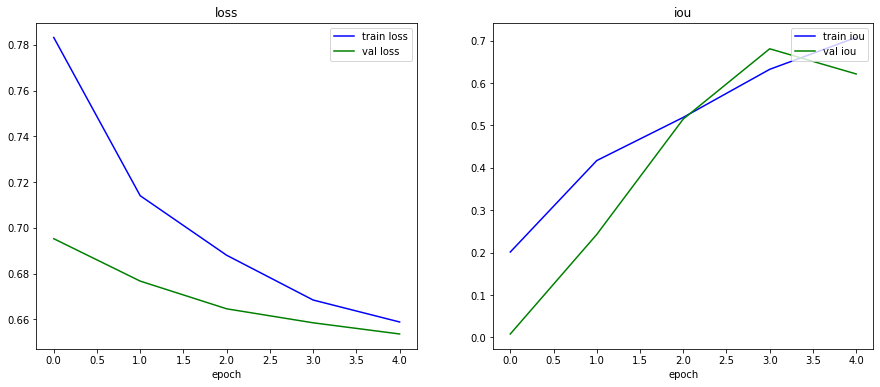

In [54]:
train_loss_data = [i.detach().cpu().numpy() for i in train_loss_list]
val_loss_data = [i.detach().cpu().numpy() for i in val_loss_list]
# train_iou_data = [i.detach().cpu().numpy() for i in train_iou_list]
# val_iou_data = [i.detach().cpu().numpy() for i in val_iou_list]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.plot(train_loss_data, 'b', label='train loss')
plt.plot(val_loss_data, 'g', label='val loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('iou')
plt.xlabel('epoch')
plt.plot(train_iou_list, 'b', label='train iou')
plt.plot(val_iou_list, 'g', label='val iou')
plt.legend(loc='upper right')

plt.show()

Test 실제값, 예측값 시각화

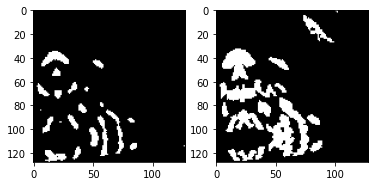

In [55]:
""" prediction / ground truth visualization """
for img_, mask_ in valid_loader:
    img = img_[1].to(device)
    img.unsqueeze_(0)
    mask_pred = model3(img.float())
    mask_pred = mask_pred.cpu()
    mask_pred = (mask_pred > 0.75)
    mask_true = mask_[1]

    img = TF.to_pil_image(mask_pred.float().squeeze(0))
    mask = TF.to_pil_image(mask_true)

    img = np.array(img)
    mask = np.array(mask)

    fig, (axis_1, axis_2) = plt.subplots(1, 2)
    axis_1.imshow(img.astype(np.uint8), cmap='gray')
    axis_2.imshow(mask.astype(np.uint8), cmap='gray')
    plt.show()

    break

# PATH = 'unet-iou-cvc.pt'
# torch.save(model.state_dict(), PATH)

- OpenCV Data Augmentation 기법을 적용하여 진행되었을 때는 마지막 epoch에서 Train IoU가 0.71, Validation IoU가 0.62 정도입니다.
- 시각화 결과 음 징징이가 나온 것을 확인할 수 있습니다 ㅋㅋㅋ

### 4) 결론
<img src ="https://drive.google.com/uc?export=view&id=1oBqi0lJ2xMgwu2SaDPgOZrrYKM6e3ICY">

- IoU값을 비교해서 표로 만들어본 결과입니다.
- OpenCV를 적용하였을 때, Augmentation 기법을 적용하지 않았을 때보다 결과값이 좋습니다. 하지만 시각화 한 영상을 보면 전혀 그렇지 않아 보입니다. Epoch 값을 좀 더 올려서 확인해보면 좋을 것 같습니다.
- 전체적인 결과를 비교해보면, U-Net 논문의 Augmentation의 결과값이 대체적으로 좋았다고 얘기할 수 있습니다.


### [마무리]

- 이렇게 세 가지 모형에 대하여 각각 동일한 Augmentation을 하여 결과값을 비교해 보았습니다!
- 처음 이 프로젝트를 할 때는 굉장히 많은 고민을 했었는데, 저희는 위 과정에 어떻게 하면 OpenCV를 이용할 수 있을까? 이런 생각으로 게시글 작성을 했습니다!
- OpenCV를 적용하는 과정, 모형을 학습시키는 과정, 데이터를 추출하는 과정에서 에러들이 많이 떴지만, 팀원들의 노력으로 무사히 게시글을 완성할 수 있었습니다!
- 후기글로 찾아뵙겠습니다. 수고하셨습니다.

# 감사합니다 ~:)